# Evaluating Performace of Registration Methods

In [1]:
%matplotlib widget
import numpy as np
import os
import matplotlib.pyplot as plt

import planeslam.io as io
from planeslam.geometry.util import quat_to_rot_mat

Read in airsim LiDAR and pose data

In [2]:
# Read in point cloud data
binpath = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_20_samples_1', 'lidar', 'Drone0')
PC_data = io.read_lidar_bin(binpath)

In [3]:
# Read in ground-truth poses (in drone local frame)
posepath = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_20_samples_1', 'poses', 'Drone0')
drone_positions, drone_orientations = io.read_poses(posepath)

Compute the ground truth rotations and transformations

In [4]:
# Compute the ground truth rotations
gt_R = []
for drone_orientation in drone_orientations[1:]:
    gt_R.append(quat_to_rot_mat(drone_orientation))

# Compute the groud truth translations
gt_t = drone_positions[1:] - drone_positions[0]

Evaluate the Perfomance of the Registration Methods

In [5]:
def get_R_t(filename):
    transformations = np.load(os.path.join(os.getcwd(),'registration', filename))
    R = transformations[:,:3,:3]
    t = transformations[:,:3,3]
    return R, t

p2p_R, p2p_t = get_R_t('p2p_abs_traj_transformations.npy')
p2l_R, p2l_t = get_R_t('p2l_abs_traj_transformations.npy')
l2l_R, l2l_t = get_R_t('l2l_abs_traj_transformations.npy')

In [6]:
def get_t_error(target_t, pred_t):
    t_errors = np.zeros(len(target_t))
    for i in range(len(target_t)):
        t_errors[i] =  np.linalg.norm(pred_t[i] - target_t[i])
    return np.sum(t_errors)

def get_R_error(target_R, pred_R):
    R_errors = np.zeros(len(target_R))
    for i in range(len(target_R)):
        R_errors[i] = np.linalg.norm(pred_R[i] @ np.linalg.inv(target_R)[i] - np.eye(3))
    return np.sum(R_errors)

p2p_t_error = get_t_error(gt_t, p2p_t)
p2p_R_error = get_R_error(gt_R, p2p_R)
print(f'Point-to-Point translational error: {p2p_t_error}')
print(f'Point-to-Point rotational error: {p2p_R_error}')

p2l_t_error = get_t_error(gt_t, p2l_t)
p2l_R_error = get_R_error(gt_R, p2l_R)
print(f'Point-to-Plane translational error: {p2l_t_error}')
print(f'Point-to-Plane rotational error: {p2l_R_error}')

l2l_t_error = get_t_error(gt_t, l2l_t)
l2l_R_error = get_R_error(gt_R, l2l_R)
print(f'Plane-to-Plane translational error: {l2l_t_error}')
print(f'Plane-to-Plane rotational error: {l2l_R_error}')

Point-to-Point translational error: 576.6921489844617
Point-to-Point rotational error: 3.4281935755668775
Point-to-Plane translational error: 303.8983421811991
Point-to-Plane rotational error: 0.1880439605409417
Plane-to-Plane translational error: 734.1974390369736
Plane-to-Plane rotational error: 50.14086851370788


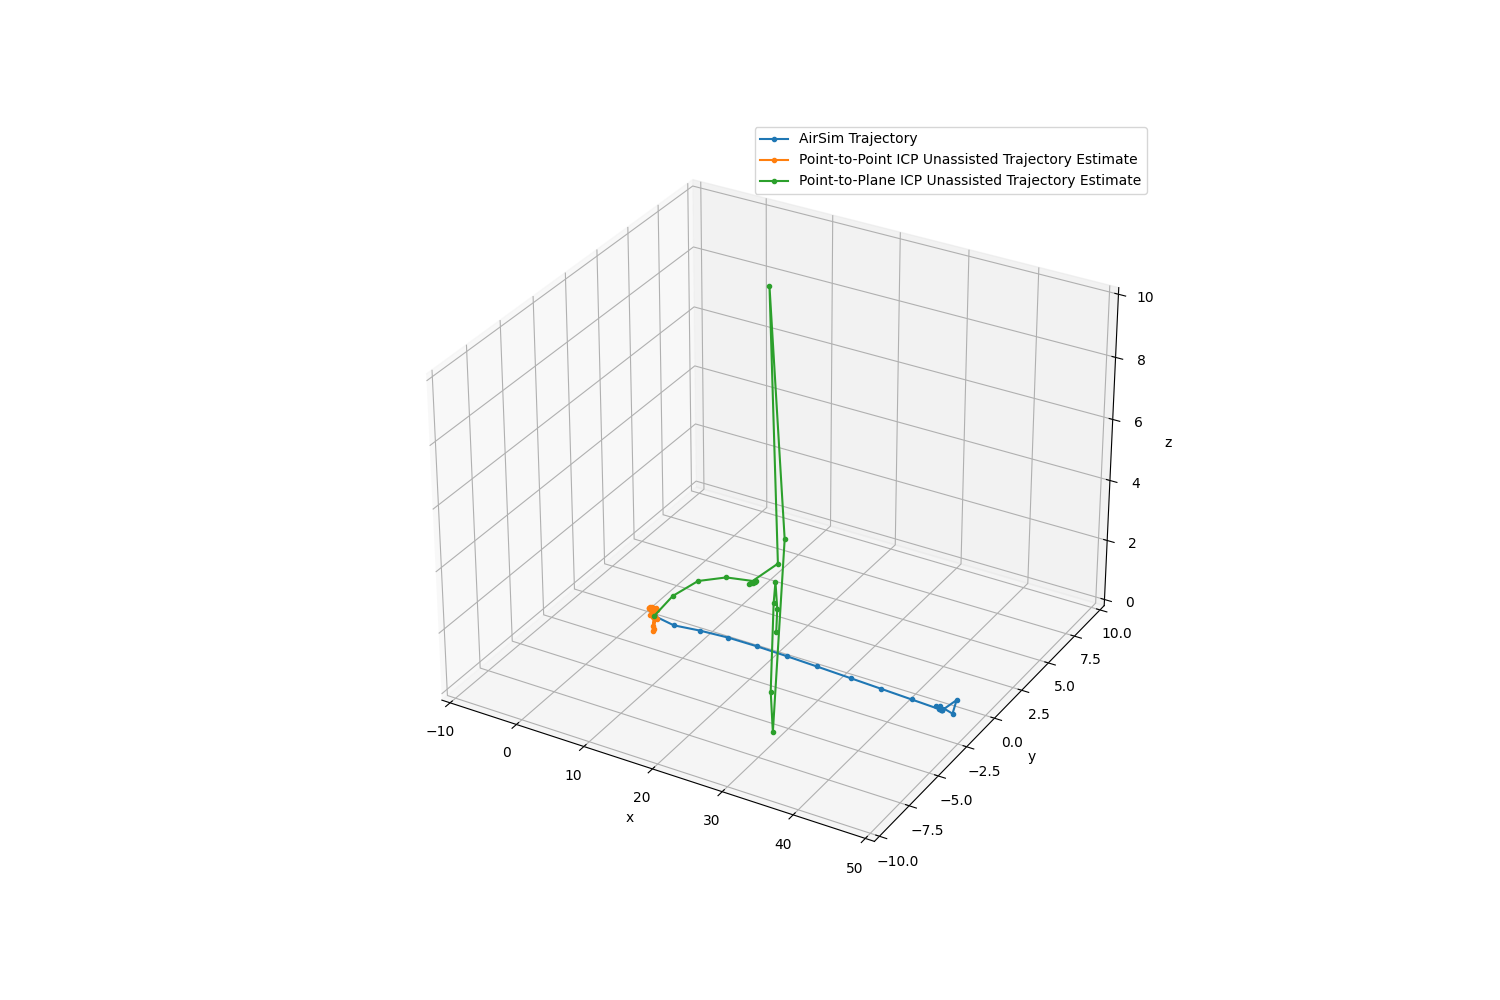

In [7]:
# Plot the points
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.plot3D(gt_t[:,0], gt_t[:,1], -gt_t[:,2], marker='.') 
ax.plot3D(p2p_t[:,0], p2p_t[:,1], -p2p_t[:,2], marker='.')
ax.plot3D(p2l_t[:,0], p2l_t[:,1], -p2l_t[:,2], marker='.')
#ax.plot3D(l2l_t[:,0], l2l_t[:,1], -l2l_t[:,2], marker='.')
ax.axes.set_xlim3d(left=-10, right=50) 
ax.axes.set_ylim3d(bottom=-10, top=10) 
ax.axes.set_zlim3d(bottom=0, top=10)
ax.axes.set_xlabel('x')
ax.axes.set_ylabel('y')
ax.axes.set_zlabel('z')
ax.legend(['AirSim Trajectory', 'Point-to-Point ICP Unassisted Trajectory Estimate', 'Point-to-Plane ICP Unassisted Trajectory Estimate'])
#ax.legend(['AirSim Trajectory', 'Point-to-Point ICP Estimated Trajectory', 'Point-to-Plane ICP Estimated Trajectory', 'Plane-to-Plane ICP Estimated Trajectory'])
#plt.title('Comparison of Trajectory Estimates between Registration Methods')
plt.savefig('Comparison_of_Trajectories')